In [3]:
import torch
import torch.nn.utils.prune as prune

class ThresholdPruning(prune.BasePruningMethod):
    PRUNING_TYPE = "unstructured"

    def __init__(self, threshold):
        self.threshold = threshold

    def compute_mask(self, tensor, default_mask):
        return torch.abs(tensor) > self.threshold

In [4]:
import torch 

def corr_coeff(x,y):
    """
    Function that computes coelation coefficient between two tensors with same size
    Returns
    -------
    corr: 
        correlation coefficient between x and y
    """ 
    vx = x - torch.mean(x)
    vy = y - torch.mean(y)

    corr= torch.sum(vx * vy) / (torch.sqrt(torch.mean(vx ** 2)) * torch.mean(torch.mean(vy ** 2)))
        
    corr = torch.clamp(corr,-1.0,1.0)
    return corr

In [9]:
import torch.nn as nn
import torch 
import numpy as np
import copy
import torch.nn.utils.prune as prune


class LSTM(nn.Module):
    
    def __init__(self, input_dim, output_dim, seq_len, n_hidden= 10 , n_layers = 1, fixed_pt_quantize = False):
        """
        Function that initializes our lstm netwrok with two lstm layers and one linear layer
        Parameters
        ----------
        input_dim: int
            number of features
        output_dim: int
            pediction's dimension
        seq_len: int
            length of sequence of data
        n_hidden: int
            number of hidden nodes of eacch lstm layer
        n_layers: int
            number of layers in each lstm layer
        fixed_pt_quantize: boolean
            if set fixed point qunatization will a applied
      
        """
        super().__init__()
        self.n_hidden = n_hidden
        self.n_layers = n_layers
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.seq_len = seq_len

        
        #lstm layers
        self.lstm = nn.LSTM(self.input_dim, self.n_hidden, self.n_layers, batch_first=False)
        #linear layer
        self.fc = nn.Linear(self.n_hidden, self.output_dim)
        #activation function
        self.act = nn.Sigmoid()
      
    def threshold_pruning(self):
        """
        Function that pruns the weights
        """

        for k in range(self.n_layers):
            parameters_to_prune = ((self.lstm, "weight_ih_l"+str(k)), (self.lstm, "weight_hh_l"+str(k)))
            prune.global_unstructured(parameters_to_prune, pruning_method=ThresholdPruning, threshold= 0.125)
        


    def forward(self, input, hidden, bin_=False, quant=False):
        """
        Function that forward pass through the network 
        Parameters
        ----------
        TrainX: matrix of shape [#datapoints, seq_len, input_dim]
            contain feature vectors of train data
        hidden: pair of matrices of shape [n_layer, batch_size, n_hidden]
            hidden/cell state of LSTM layers
        bin_: boolean
            if set, the network is binarized
        quant: boolean
            if set, the network is quantized
        Returns
        -------
        out: matrix of shape [seq_len, batch_size, n_hidden]
            scaler used to standardize the data
        hidden: pair of matrices of shape [n_layer, batch_size, n_hidden]
            hidden/cell state of LSTM layers
        """ 
        ##our input has shape [batch_size, seq_len, input_dim] but lstm wants [seq_len, batch_size, input_dim], we need to reconstrcut the input the way lstm wants:
        new_input = torch.ones((self.seq_len, input.shape[0], self.input_dim))
        for i in range(self.seq_len):
            new_input[i] = input[:,i,:]

        r_output, hidden = self.lstm(new_input, hidden)
        
    
        ## put x through the fully-connected layer
        out = self.act(r_output)
        out = self.fc(out)
        
        return out, hidden


    def init_hidden(self, batch_size):
        """
        Function that initializes hidden state
        Parameters
        ----------
        batch_size: int
            batch size!
        Returns
        -------
        hidden: pair of matrices of shape [n_layer, batch_size, n_hidden]
            hidden/cell state of LSTM layers
        """ 
        # Create two new tensors with sizes n_layers x n_hidden,
        # initialized to zero, for hidden state and cell state of LSTM
        hidden_state = torch.zeros(self.n_layers, batch_size, self.n_hidden)
        cell_state = torch.zeros(self.n_layers, batch_size, self.n_hidden)
        hidden = (hidden_state, cell_state)

        return hidden

Run for subject 10 finger 0
Baseline ===================================================================
Epoch [1/2], Loss: 0.2641
Correlation coefficient train : 0.003967322233571132
Correlation coefficient validation: 0.012257746673844043
Correlation coefficient test: 7.611981829669507e-05
Epoch [2/2], Loss: 0.2377
Correlation coefficient train : 0.016128080340051833
Correlation coefficient validation: 0.005914392940892592
Correlation coefficient test: -0.022781252228760006
Pruning============================================================================
Epoch [1/2], Loss: 0.2130
Correlation coefficient train : 0.03382977351641301
Correlation coefficient validation: 0.016758406436650358
Correlation coefficient test: -0.022131684933127817
Epoch [2/2], Loss: 0.1915
Correlation coefficient train : 0.03812967169948683
Correlation coefficient validation: 0.012531726565054172
Correlation coefficient test: -0.03504524263005223
Correlation coefficient test : -0.03504479810286855


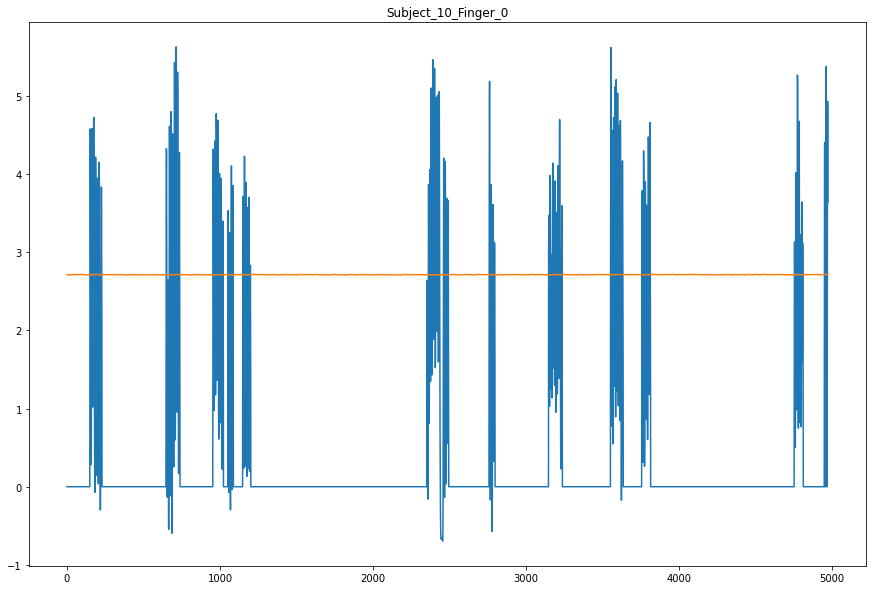

In [15]:
import numpy as np
import scipy.io as sio 
import torch.nn as nn
import torch 
import matplotlib.pyplot as plt
import os
import argparse
import pickle

#from preprocessing_funcs import get_spikes_with_history, preprocessing, remove_outliers
#from model import LSTM
#from trainer import train
#from pruning import ThresholdPruning
#from 

#set this to the root directory where you want to save and load data and figures
root = os.path.join('drive')
#set this to the diectory where you want to save data and checkpoints
data_path = os.path.join(root, 'data')
#set this to the diectory where you want to save checkpoints
#set this to directory where you want to save figures
figure_path = 'figs'
checkpoint_path = 'res'
# thresholds values used in the report : 0.05; 0.1; 0.125; 0.15
threshold = 0.125

for Idx_subject in list([10]): # 3 subjects index 10-12

        for Finger in list([0]): # 5 fingers for each subject. 0:thumb, 1:index, 2:middle ...
            
            #load training data (TrainX: feature vectors, TrainY: labels)
            matData = sio.loadmat('BCImoreData_Subj_'+str(Idx_subject)+'_200msLMP.mat')
            TrainX = matData['Data_Feature'].transpose()
            TrainY = matData['SmoothedFinger']
            TrainY = TrainY [:,Finger]
            TrainY = TrainY.reshape(TrainY.shape[0],1)
            #load testing data (TestX: feature vectors, TestY: labels)
            matData = sio.loadmat('BCImoreData_Subj_'+str(Idx_subject)+'_200msLMPTest.mat')
            TestX = matData['Data_Feature'].transpose()
            TestY = matData['SmoothedFinger']
            TestY = TestY[:,Finger]
            TestY = TestY.reshape(TestY.shape[0],1)
            
            # preprocessing 
            TrainX = remove_outliers(TrainX)
            
            x_scaler, y_scaler, TrainX, TestX, TrainY, TestY  = preprocessing(TrainX,TestX,TrainY,TestY)
            
            
            # from here, we reconstruct the input by "looking back" a few steps
            bins_before= 20 #How many bins of neural data prior to the output are used for decoding
            bins_current=1 #Whether to use concurrent time bin of neural data
            bins_after=0 #How many bins of neural data after the output are used for decoding
            
            TrainX=get_spikes_with_history(TrainX,bins_before,bins_after,bins_current)
            TrainX, TrainY = TrainX[bins_before:,:,:], TrainY[bins_before:,]
         
            TestX=get_spikes_with_history(TestX,bins_before,bins_after,bins_current)
            TestX, TestY = TestX[bins_before:,:,:], TestY[bins_before:,]
            
            # Now, we reconstructed TrainX/TestX to have a shape (num_of_samples, sequence_length, input_size)
            # We can fit this to the LSTM
            
            print("Run for subject " + str(Idx_subject) + " finger "+str(Finger))

            n_hidden = 20
            n_layers = 5
            input_dim = TrainX.shape[2]
            output_dim = TrainY.shape[1]
            seq_len =  TrainX.shape[1]

            net = LSTM(input_dim, output_dim, seq_len,  n_hidden, n_layers, fixed_pt_quantize = fixed_pt_quantize)

            lossfunc = nn.MSELoss()
            lr = 0.002
            optimizer = torch.optim.Adamax(net.parameters(), lr=lr)

           
            print("Baseline ===================================================================")
            ##training the initial model

            net.train()
            corr_train, corr_val, corr_test = train(TrainX, TrainY,TestX,TestY, net, lossfunc, optimizer, num_epoch = 40, clip = 5, Finger=Finger)
            net.eval()
            pred,h = net(torch.from_numpy(TestX).float(), net.init_hidden(TestX.shape[0]))

            
            ##############################################PRUNING###########################################################################
            print("Pruning============================================================================")
            PATH_pre_trained_prun = checkpoint_path + '/s'+ str(Idx_subject) + '_f'+str(Finger)+'_trained_pruned_model'
            figure_name = "/Subject_" + str(Idx_subject) + "_Finger_"+str(Finger)+"_pruning"

            
            net.train()
            # default value or threshold is 0.125
            net.threshold_pruning() 

            #train the prunned model:
            corr_train, corr_val, corr_test = train(TrainX, TrainY, TestX, TestY, net, lossfunc, optimizer, num_epoch=30, clip = 5, Finger = Finger)

            net.eval()
            pred,h = net(torch.from_numpy(TestX).float(), net.init_hidden(TestX.shape[0]))
               
          
            pred = pred.detach().numpy()[-1,:,:]
            pred = y_scaler.inverse_transform(pred)
            TestY = y_scaler.inverse_transform(TestY)
            pred = pred.reshape((-1,))
            corrcoef = np.corrcoef(pred,TestY.reshape((-1,)))

            TestYShifted = TestY
            #pred_tf = scaler.inverse_transform(pred)
            x = np.arange(TestYShifted.shape[0])
            
           
            fig_label = plt.figure(figsize=(15,10))
            plt.title("Subject_" + str(Idx_subject) + "_Finger_"+str(Finger))
            plt.plot(x, TestYShifted)
            plt.plot(x, pred)
            fig_label.savefig(figure_path + figure_name)

            
            print ('Correlation coefficient test : {corrcoef}'.format(corrcoef=corrcoef[0,1]))   